## This is just like the long cadence version but is MUCH SLOWER

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits as pyfits
from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label

from fit_funcs import (bg_sub, get_label_im, get_lc, transit_fit,
                       get_qf, bin_data, model_ktransit, plot_model)
%load_ext autoreload
%autoreload 2
import untrendy

try:
    from blssearch import doSearch, plotSearch, get_qf
    dobls = True
except ImportError:
    dofls = False
    
from tqdm import tqdm

# i saved some dictionaries with planet parameters
from planet_params import *

# because I'm being sloppy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [2]:
f = pyfits.open('k2-trappist1-unofficial-tpf-short-cadence-v20170322.fits')
data = f[1].data
print('{} cadences'.format(f[1].data['FLUX'].shape[0]))
print('pixel mask is {}'.format(f[1].data['FLUX'].shape[1:3]))

107968 cadences
pixel mask is (11, 11)


lets take a look at what the star looks like

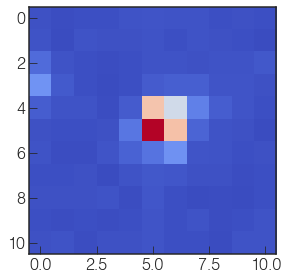

In [3]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

These are some constants that I fiddled around with a found seemed to work best

In [4]:
bg_cut = 0.8
n_chunks = 7.
flatlc_window = 1.5
smooth_window = 0.6

I'm going to extract flux from the flagged pixels

In [5]:
lab_im = get_label_im(np.copy(f[1].data['FLUX']), bg_cut)



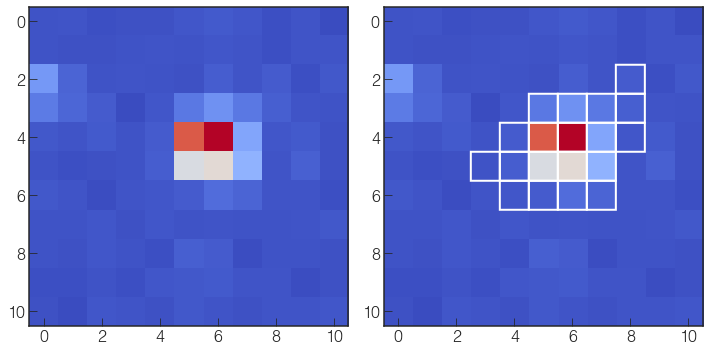

In [6]:
fig, [ax1,ax] = plt.subplots(1, 2, figsize=[10,5])
ax.imshow(np.sqrt(np.abs(f[1].data['FLUX'][20008])), cmap='coolwarm', aspect='equal', interpolation='nearest')
ax1.imshow(np.sqrt(np.abs(f[1].data['FLUX'][20008])), cmap='coolwarm', aspect='equal', interpolation='nearest')
for i in range(11):
    for j in range(11):
        if lab_im[j,i] == 1:
            ax.add_patch(mpl.patches.Rectangle((i-.5, j-.5), 1, 1, hatch='', fill=False, snap=False, color='w', 
                                               lw=2))

plt.tight_layout()
plt.savefig('images/pixelmask.png')

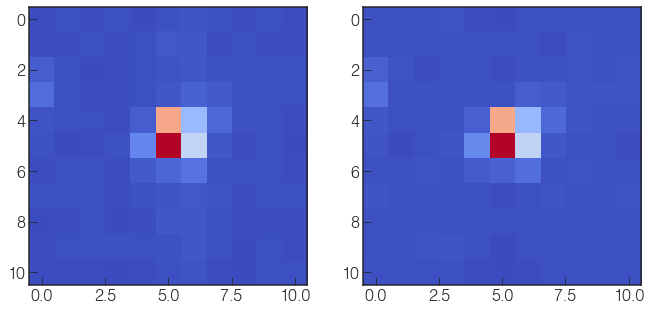

In [7]:
w= np.copy(f[1].data['FLUX'][67485])
fig, [ax1,ax] = plt.subplots(1, 2, figsize=[10,5])
ax.imshow(w - np.median(w, axis=0), cmap='coolwarm', aspect='equal', interpolation='nearest')
ax1.imshow(w - np.median(w), cmap='coolwarm', aspect='equal', interpolation='nearest')

I'm going to remove some cadences where we fire a thruster and remove energy from the reaction wheels, called a resat. Also, something weird happens with the pointing at the end of the campaign

100%|██████████| 107968/107968 [00:06<00:00, 17520.73it/s]


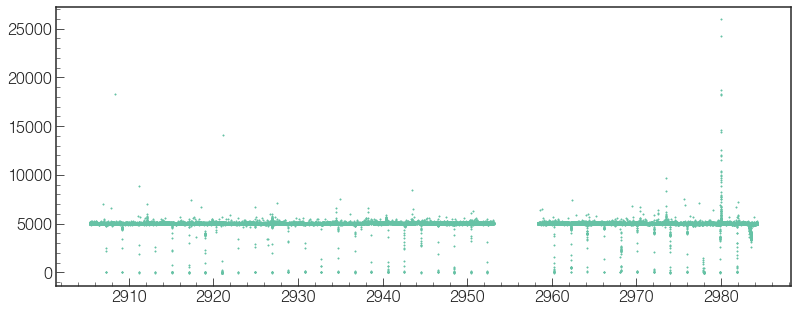

In [8]:
q1 = np.array([])
bgf = bg_sub(np.copy(f[1].data['FLUX']))
# for i in tqdm(np.arange(f[1].data['TIME'].shape[0])):
#     q1 = np.r_[q1,np.sum(f[1].data['FLUX'][i][lab_im > 0.0])]

for i in tqdm(np.arange(f[1].data['TIME'].shape[0])):
    q1 = np.r_[q1,np.sum(bgf[i][lab_im > 0.0])]

plt.figure(figsize=[12,5])
plt.scatter(f[1].data['TIME'],q1, s=2)

# q = untrendy.median(f[1].data['TIME'],q1,dt=2)

# plt.scatter(f[1].data['TIME'][(q1-q)<-500],q1[(q1-q)<-500])

# badbadbad = (q1-q)<-500

plt.minorticks_on()
# plt.savefig('images/rawlc.png')

In [9]:
np.savetxt('crapdata-smear.txt', np.array([f[1].data['TIME'],q1/np.median(q1) - 1.0]).T)

ok now let's make a light curve, this uses a methods that's almost exactly like Andrew Vanderburg's

In [10]:
# quality = np.zeros_like(np.copy(f[1].data['TIME']))
# time = np.copy(f[1].data['TIME'])
# fluxarr = np.copy(f[1].data['FLUX'])
# # quality[badbadbad] = 100.

# fluxarr[fluxarr == 0] = np.nan

# flux_b = bg_sub(fluxarr)

In [11]:
# from photo_test import raw_moment, intertial_axis, plot_bars

# flatim = np.nanmedian(flux_b,axis=0)
# vals = flatim[np.isfinite(flatim)].flatten()
# mad_cut = 1.4826 * MAD(vals) * bg_cut

# flatim[np.isnan(flatim)] = 0.
# region = np.where(flatim > mad_cut,1,0)
# lab = label(region)[0]

# imshape = np.shape(flatim)
# centralpix = [1+imshape[0] // 2,1+imshape[1] // 2]

# #find brightest pix within 9x9 of central pix
# #this assumes target is at center of postage stamp which I think is ok
# centflatim = flatim[centralpix[0]-2:centralpix[0]+2,
#             centralpix[1]-2:centralpix[1]+2]
# flatimfix = np.where(np.isfinite(centflatim),centflatim,0)
# brightestpix = np.unravel_index(flatimfix.argmax(), centflatim.shape)
# bpixy, bpixx = brightestpix

# #use all pixels in the postage stamp that are X MAD above the median
# #this identifies location of brightest pixel only
# regnum = lab[centralpix[0]-2+bpixy,centralpix[1]-2+bpixx]

# lc = np.zeros_like(time)
# xbar = np.zeros_like(time)
# ybar = np.zeros_like(time)

# #make a rectangular aperture for the moments thing
# ymin = np.min(np.where(lab == regnum)[0])
# ymax = np.max(np.where(lab == regnum)[0])
# xmin = np.min(np.where(lab == regnum)[1])
# xmax = np.max(np.where(lab == regnum)[1])

# momlims = [ymin,ymax+1,xmin,xmax+1]


# #loop that performs the aperture photometry
# for i,fl in enumerate(flux_b):
#     lc[i] = np.sum(fl[lab == regnum])
#     #lc[i] = np.sum(fl[np.where(lab == 1)]
#     momim = fl[momlims[0]:momlims[1],
#                 momlims[2]:momlims[3]]
#     momim[~np.isfinite(momim)] == 0.0
#     xbar[i], ybar[i], cov = intertial_axis(momim)

# xbar[~np.isfinite(xbar) | ~np.isfinite(ybar)] = np.nan
# ybar[~np.isfinite(xbar) | ~np.isfinite(ybar)] = np.nan

# xbar = xbar - np.nanmean(xbar)
# ybar = ybar - np.nanmean(ybar)

In [12]:
# m1 = np.isfinite(lc) * np.isfinite(lc)

# time = time[m1]
# lc = lc[m1]
# xbar = xbar[m1]
# ybar = ybar[m1]



In [13]:
# import extract_lc
# flatlc = extract_lc.medfilt(time,lc,window=flatlc_window)

# cadstep = np.int(np.floor(len(time) / n_chunks)) #600
# zpt = len(time) % cadstep
# if zpt==cadstep:
#     zpt = 0

# outflux, correction, thr_cad = extract_lc.run_C0_detrend(
#         time[0:60000], flatlc[0:60000], xbar[0:60000], ybar[0:60000], cadstep=cadstep, skip=None)

NameError: name 'time' is not defined

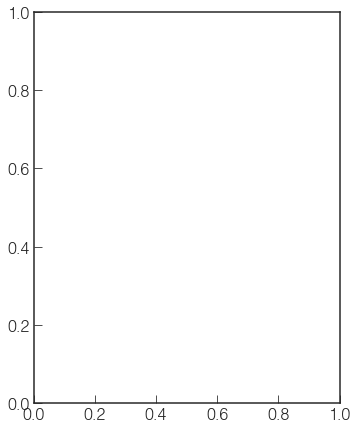

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=[5,7])

ax1.plot((time-2979.91) * 1400,lc / np.median(lc), )
ax1.set_xlim((2979.91-2979.91),(2980.05-2979.91)* 1440)
ax1.minorticks_on()

ax1.set_xlabel('Time (BJD - 2454833 - 2979.91) in minutes [sorry]', fontsize=14)
ax1.set_ylabel('Relative brightness')

# fig.savefig('images/sc-flare-maybe.png')

In [15]:
good = np.loadtxt('goodcad.txt', dtype='bool')
quality = np.ones_like(np.copy(f[1].data['TIME']))
quality[good] = 0.

In [16]:
np.shape(good), np.shape(f[1].data['TIME'])

((107968,), (107968,))

In [17]:

time, lc, xbar, ybar, t1, corflux, cfflux = get_lc(
    np.copy(f[1].data['TIME'][good]), np.copy(f[1].data['FLUX'][good]), 
    quality, n_chunks, bg_cut, flatlc_window, smooth_window)

In [18]:
np.std(cfflux) / np.sqrt(30*12) * 1.E6

345.95510548014227

In [19]:
# quality = np.zeros_like(np.copy(f[1].data['TIME']))
# # quality[badbadbad] = 100.

# # split this up
# time = []
# lc = []
# xbar = []
# ybar = []
# t1 = []
# corflux = []
# cfflux = []
# for i in tqdm(np.arange(0,107000,7000)):
#     try:
#         tx, lx, xx, yx, t1x, cox, cfx = get_lc(
#             np.copy(f[1].data['TIME'])[i:i+7000], np.copy(f[1].data['FLUX'])[i:i+7000], 
#             quality[i:i+7000], n_chunks, 2.0, flatlc_window, smooth_window)

#         time = np.r_[time,tx]
#         lc = np.r_[lc,lx]
#         xbar = np.r_[xbar, xx]
#         ybar = np.r_[ybar,yx]
#         t1 = np.r_[t1,t1x]
#         corflux = np.r_[corflux, cox]
#         cfflux = np.r_[cfflux, cfx]
#     except:
#         print('failed {}'.format(i))
#         continue

In [20]:
# i = 22600
# for j in tqdm(np.arange(i-100,i+3000,100)):
#     q1 = get_lc(np.copy(f[1].data['TIME'])[j:j+350], np.copy(f[1].data['FLUX'])[j:j+350], 
#             quality[j:j+350], n_chunks, 2.0, flatlc_window, smooth_window)

q1 = np.array([])
for i in tqdm(np.arange(f[1].data['TIME'].shape[0][22600-100])):
    q1 = np.r_[q1,np.sum(f[1].data['FLUX'][i][lab_im > 0.0])]

plt.figure(figsize=[12,5])
plt.scatter(f[1].data['TIME'],q1, s=2)

# q = untrendy.median(f[1].data['TIME'],q1,dt=2)

# plt.scatter(f[1].data['TIME'][(q1-q)<-500],q1[(q1-q)<-500])

# badbadbad = (q1-q)<-500

plt.minorticks_on()
# plt.savefig('images/rawlc.png')

TypeError: 'int' object has no attribute '__getitem__'

lets make some plots
* undetrended light curve
* undetrended and the detrending model of the spots [it's a silly median filter]
* final product

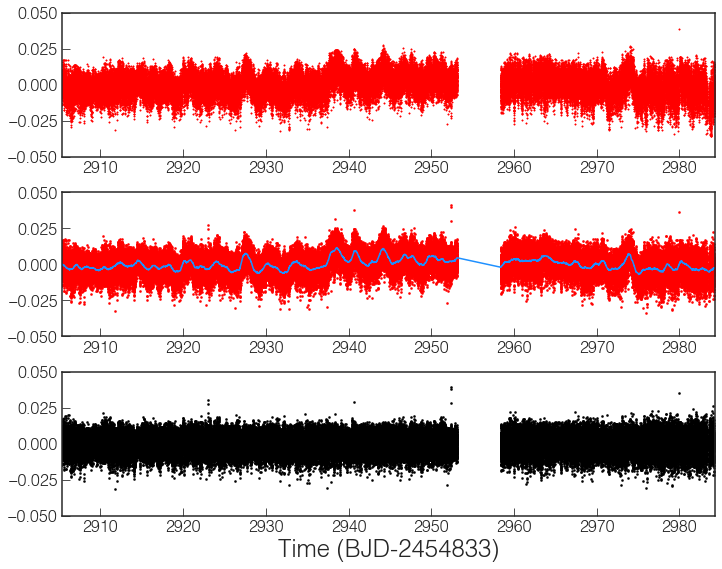

In [21]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=[10,8])
ax1.scatter(time,lc/np.median(lc)-1.0, color='r', s=2)
ax1.set_ylim([-0.05,0.05])
ax1.set_xlim(np.min(time), np.max(time))

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
ax2.set_ylim([-0.05,0.05])
ax2.set_xlim(np.min(time), np.max(time))

ax3.set_ylim([-0.05,0.05])
ax3.set_xlim(np.min(time), np.max(time))
ax3.scatter(t1,cfflux, color='k',s=4)

ax3.set_xlabel('Time (BJD-2454833)')

fig.tight_layout()
# plt.savefig('images/lcdetrending.png')

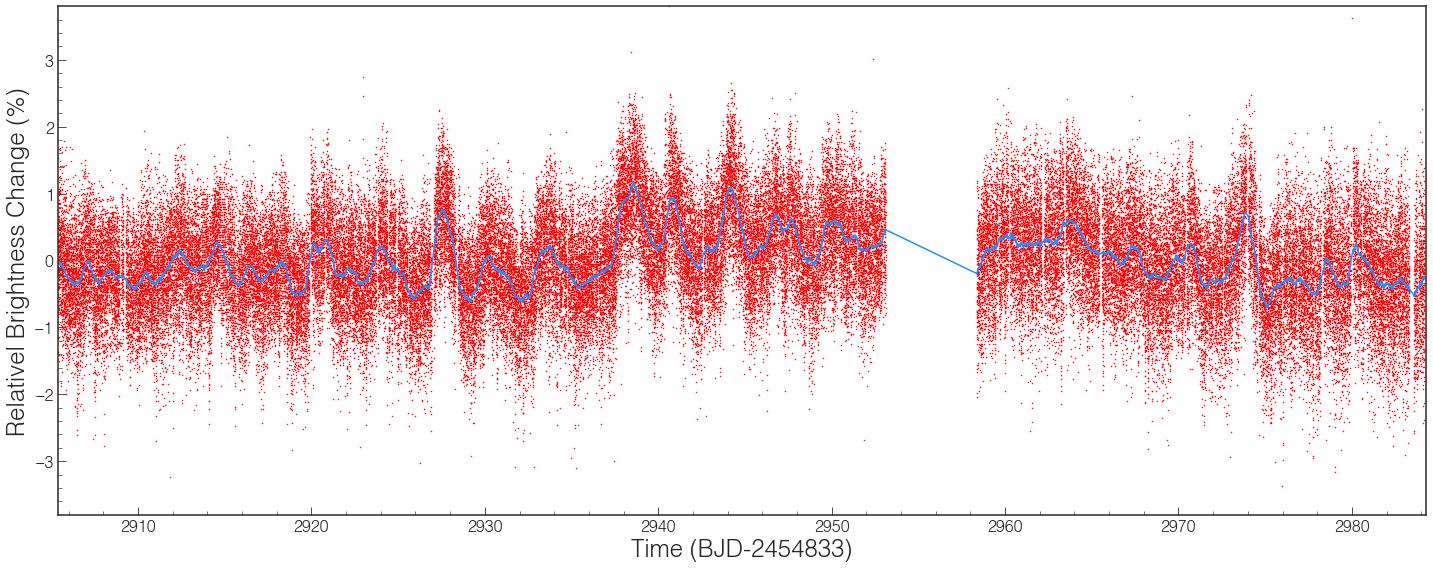

In [22]:
# I'm making a plot of just the middle panel because Geert wanted for the blog post

fig, ax2 = plt.subplots(1, 1, figsize=[20,8])

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,100*(corflux-1.0), color='r',s=1)
ax2.plot(t1, 100*(q-1.0), color='dodgerblue')
ax2.set_ylim([-3.8,3.8])
ax2.set_xlim(np.min(time), np.max(time))

ax2.set_xlabel('Time (BJD-2454833)')
ax2.set_ylabel('Relativel Brightness Change (%)')
ax2.minorticks_on()
fig.tight_layout()
# plt.savefig('images/geert-blog.png')

## hurray! let's save this data

In [23]:
outdata = np.array([t1,cfflux]).T
np.savetxt('trappist1-barclay-short-cadence-fullish.csv', outdata, delimiter=',',)

outdata = np.array([t1,corflux-1.0]).T
np.savetxt('trappist1-barclay-short-cadence-notdetrended.csv',outdata, delimiter=',')

ok, now let's try to model the planets

In [23]:
# this can take some time, we're only only going to fit 7 planets
timet, fluxt, fitT = transit_fit(t1, cfflux, cadence='short', rho=30.)

fitT.print_results() 

Best-fitting stellar parameters
zpt: 0.000198494884884
rho: 65.9457126202

Best-fitting planet parameters for planet 0
impact: 0.192479051655
period: 1.51090331228
T0: 7322.50854652
rprs: 0.081496367478

Best-fitting planet parameters for planet 1
impact: 0.134776351845
period: 2.42179722919
T0: 7282.81114927
rprs: 0.0789763981778

Best-fitting planet parameters for planet 2
impact: -0.0222167197044
period: 4.0498892561
T0: 7670.14301686
rprs: 0.0570096850943

Best-fitting planet parameters for planet 3
impact: 0.21008407202
period: 6.09884537247
T0: 7660.38680463
rprs: 0.0631706032759

Best-fitting planet parameters for planet 4
impact: 0.463607957206
period: 9.20663458603
T0: 7671.37595666
rprs: 0.073073974413

Best-fitting planet parameters for planet 5
impact: 0.434017101853
period: 12.3539259433
T0: 7665.36034816
rprs: 0.0792955304672

Best-fitting planet parameters for planet 6
impact: 0.739572418641
period: 18.7732906954
T0: 7756.38215058
rprs: 0.0642617213582



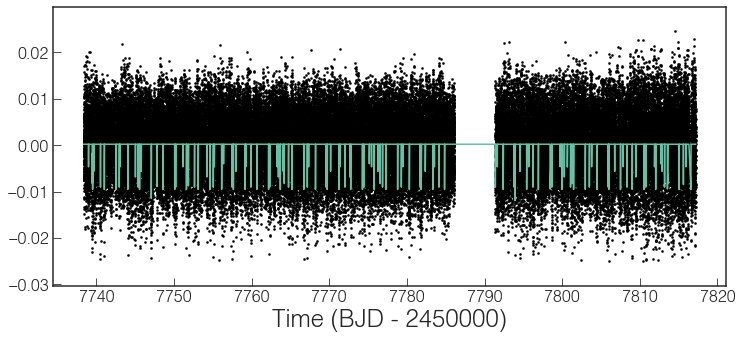

In [24]:
# here are all the transits!!
fig, ax = plt.subplots(1, 1, figsize=[11,5])
ax.scatter(timet,fluxt, color='k',s=4)
ax.plot(timet,fitT.transitmodel)
# ax.set_ylim(-0.015,0.009)
ax.set_xlabel('Time (BJD - 2450000)')
# plt.savefig('images/lc-with-model.png')

In [25]:
# some stellar parameters
ld1 = 1.0181
ld2 = -0.0404
zpt = fitT.fitresultstellar['zpt']
rho = fitT.fitresultstellar['rho']

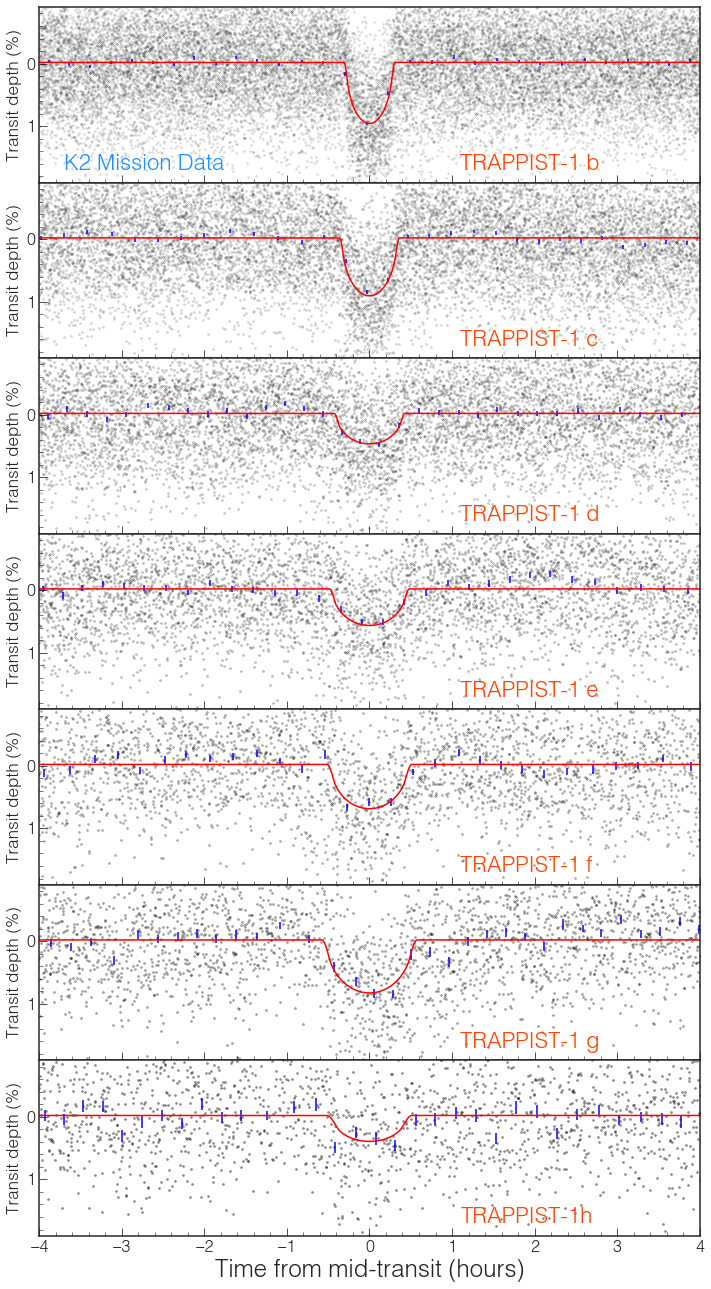

In [26]:
from fit_funcs import plot_model_sc
import fit_funcs
reload(fit_funcs)
nplanets=7
fig, axes = plt.subplots(nplanets, 1, figsize=[10,18])
labels = ['TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 
          'TRAPPIST-1h']
for i,p in enumerate(['pnum0','pnum1','pnum2','pnum3','pnum4','pnum5', 'pnum6']):
    axes[i] = fit_funcs.plot_model_sc(axes[i],timet,fluxt, rho, zpt, ld1, ld2, fitT.fitresultplanets[p], cadence='short')
    axes[i].tick_params(labelbottom=False)
    axes[i].set_ylim(1.9,-0.9)
    axes[i].text(1.1,1.7,labels[i], fontsize=22, color='orangered')
axes[0].text(-3.7,1.7,'K2 Mission Data', fontsize=22, color='dodgerblue')
axes[-1].set_xlabel('Time from mid-transit (hours)')
axes[-1].tick_params(labelbottom=True)
fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=0)
# plt.savefig('images/transitmodel-sc.png')

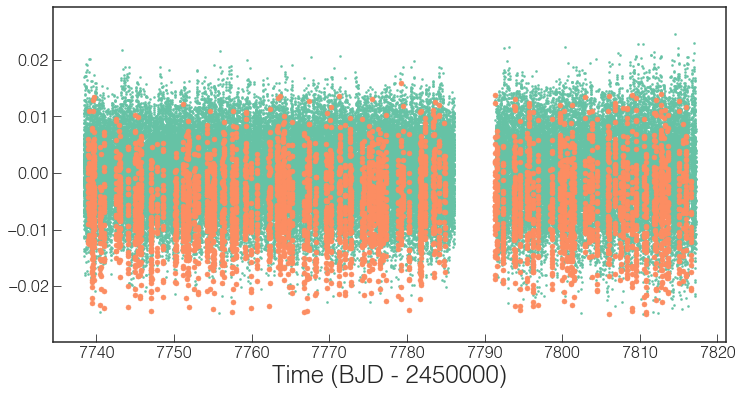

In [27]:
# data in/out of transit
fig, ax = plt.subplots(1, 1, figsize=[11,6])
ax.scatter(timet[fitT.transitmodel > 0],fluxt[fitT.transitmodel > 0], s=4)
ax.scatter(timet[fitT.transitmodel <= 0],fluxt[fitT.transitmodel <= 0], s=25)
ax.set_xlabel('Time (BJD - 2450000)')

### ok let's search for another planets... planet h?

In [28]:
# Main transit search
minPeriod = 15.    # Limitations of BLS Fortran code
maxPeriod = 25#(time[-1] - time[0]) /3.

outs = doSearch(timet,fluxt - fitT.transitmodel, minPeriod, maxPeriod, )
# outs = doSearch(timet[fitT.transitmodel > 0], fluxt[fitT.transitmodel > 0], minPeriod, maxPeriod, )

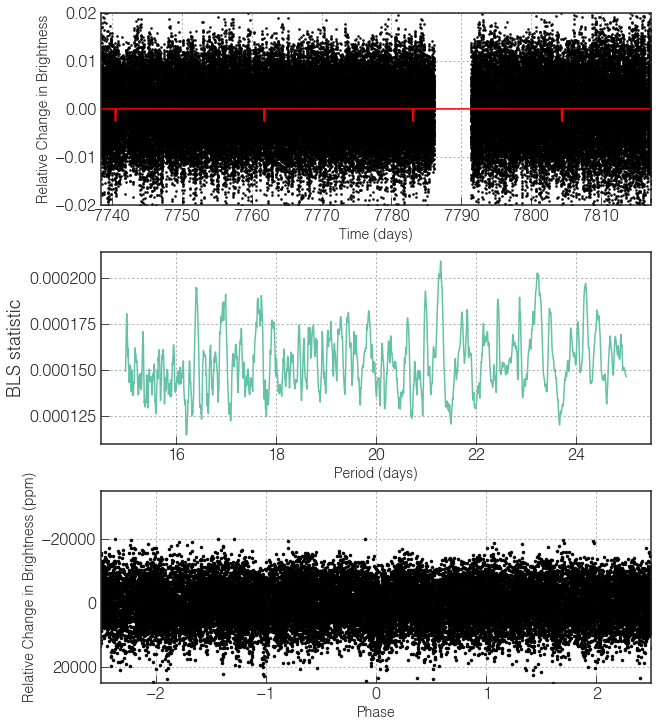

In [29]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[9,12])
ax1.scatter(timet,fluxt, color='k',s=4)
ax1.plot(timet, outs['transitModel'] , color='r') 
# ax1.plot(timet[fitT.transitmodel > 0], outs['transitModel'] , color='r') 
ax1.set_ylim([-0.02,0.02])
ax1.set_xlim(np.min(timet), np.max(timet))
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Change in Brightness', fontsize=14)
ax1.grid()
ax2.grid()
ax3.grid()

#ax2.plot(time, flux ) 
ax2.plot(outs['period_guesses'], outs['convolved_bls'])
ax2.set_xlabel('Period (days)', fontsize=14)
ax2.set_ylabel('BLS statistic', fontsize=18)
# q,f = get_qf(timet[fitT.transitmodel > 0], fluxt[fitT.transitmodel > 0], outs['epoch'], outs['period'])
q,f = get_qf(timet, fluxt, outs['epoch'], outs['period'])
ax3.scatter(q,f, s=9, c='k')
ax3.set_ylim([np.max(f),-35000])
#ax3.set_xlim([np.max(q),np.min(q)])
ax3.set_xlim([-2.5,2.5])
ax3.set_xlabel('Phase', fontsize=14)
ax3.set_ylabel('Relative Change in Brightness (ppm)', fontsize=14)


# this isn't very convincing, other poeple are going to do much better :)

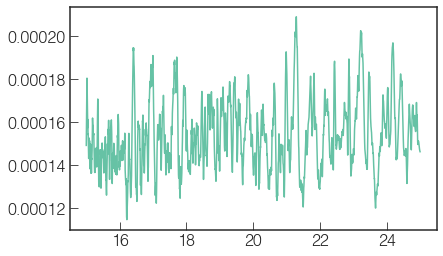

In [30]:
plt.plot(outs['period_guesses'], outs['convolved_bls'])

(16, 18)

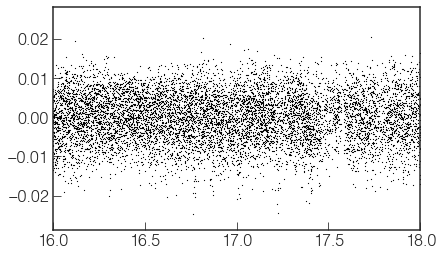

In [31]:
plt.scatter(timet%18.765,fluxt, color='k',s=0.5)
plt.xlim(16,18)

In [32]:
2979.67 - (3*18.765)
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

(2941.14463, 2943.14463)

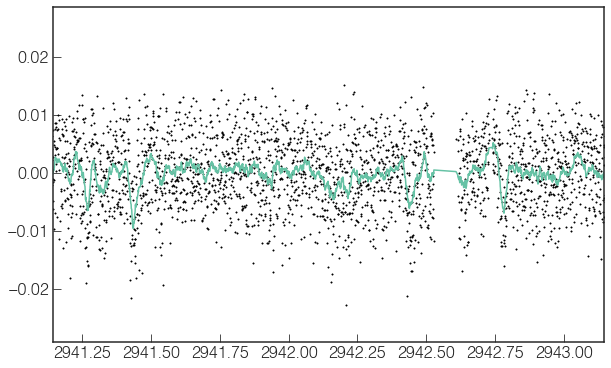

In [33]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(timet-4833,fluxt, color='k',s=2)
plt.plot(timet[15:-14]-4833,moving_average(fluxt, n=30))
plt.xlim(2942.14463-1,2942.14463+1)

In [34]:
b = np.digitize(timet, bins=np.linspace(np.min(timet), np.max(timet), 2000),)
med = np.array([(np.median(fluxt[b == bx])) for bx in np.unique(b)])
medt = np.array([(np.median(timet[b == bx])) for bx in np.unique(b)])

(2941.14463, 2943.14463)

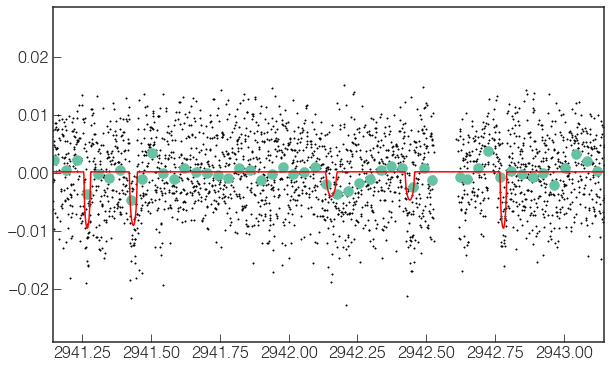

In [35]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(timet-4833,fluxt, color='k',s=2)
plt.plot(timet-4833,fitT.transitmodel, color='r')
plt.scatter(medt-4833,med,s=100)
plt.xlim(2942.14463-1,2942.14463+1)

(2922.37963, 2924.37963)

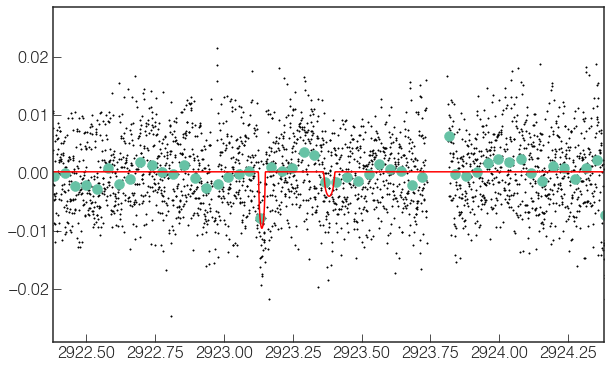

In [36]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(timet-4833,fluxt, color='k',s=2)
plt.plot(timet-4833,fitT.transitmodel, color='r')
plt.scatter(medt-4833,med,s=100)
plt.xlim(2923.37963-1,2923.37963+1)

(2959.90963, 2961.90963)

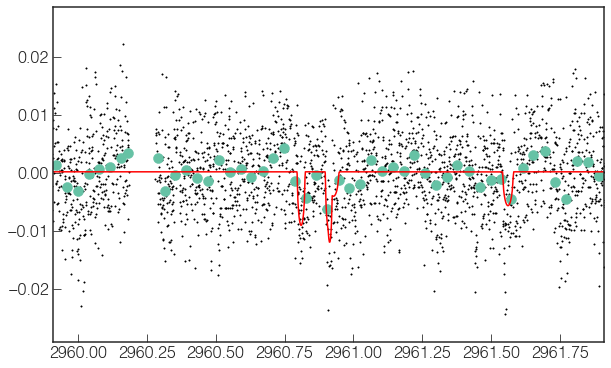

In [37]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(timet-4833,fluxt, color='k',s=2)
plt.plot(timet-4833,fitT.transitmodel, color='r')
plt.scatter(medt-4833,med,s=100)
plt.xlim(2960.90963-1,2960.90963+1)

(2979.17463, 2980.17463)

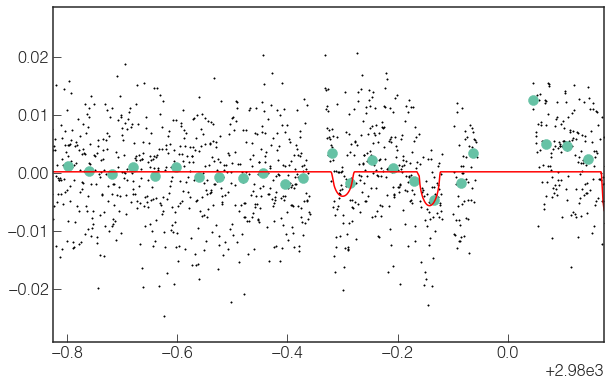

In [38]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(timet-4833,fluxt, color='k',s=2)
plt.plot(timet-4833,fitT.transitmodel, color='r')
plt.scatter(medt-4833,med,s=100)
plt.xlim(2979.67463-0.5,2979.67463+0.5)

TypeError: sequence index must be integer

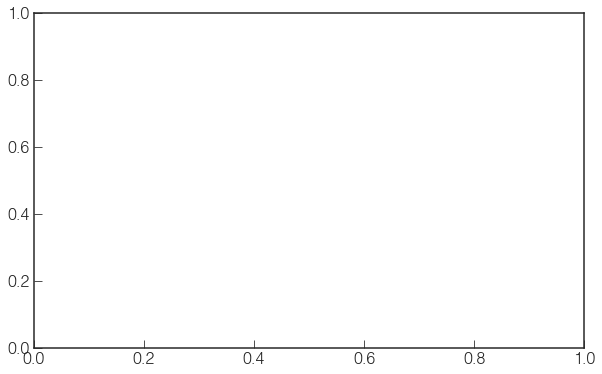

In [39]:
fig, ax1 = plt.subplots(1,1,figsize=[9,6])
plt.scatter(f[1].data['TIME'],q1/np.median(q1) - 1.0, color='r',s=2)
plt.scatter(f[1].data['TIME'][good],q1[good]/np.median(q1[good]) - 1.0, color='k',s=2)
plt.plot(timet-4833,fitT.transitmodel, color='r')
plt.scatter(medt-4833,med,s=100)
plt.scatter(2979.67463,0.0,s=100)
plt.xlim(2979.67463-0.2,2979.67463+0.2)
plt.ylim(-0.025,0.025)

In [40]:
q = untrendy.median(t1,corflux,dt=smooth_window)

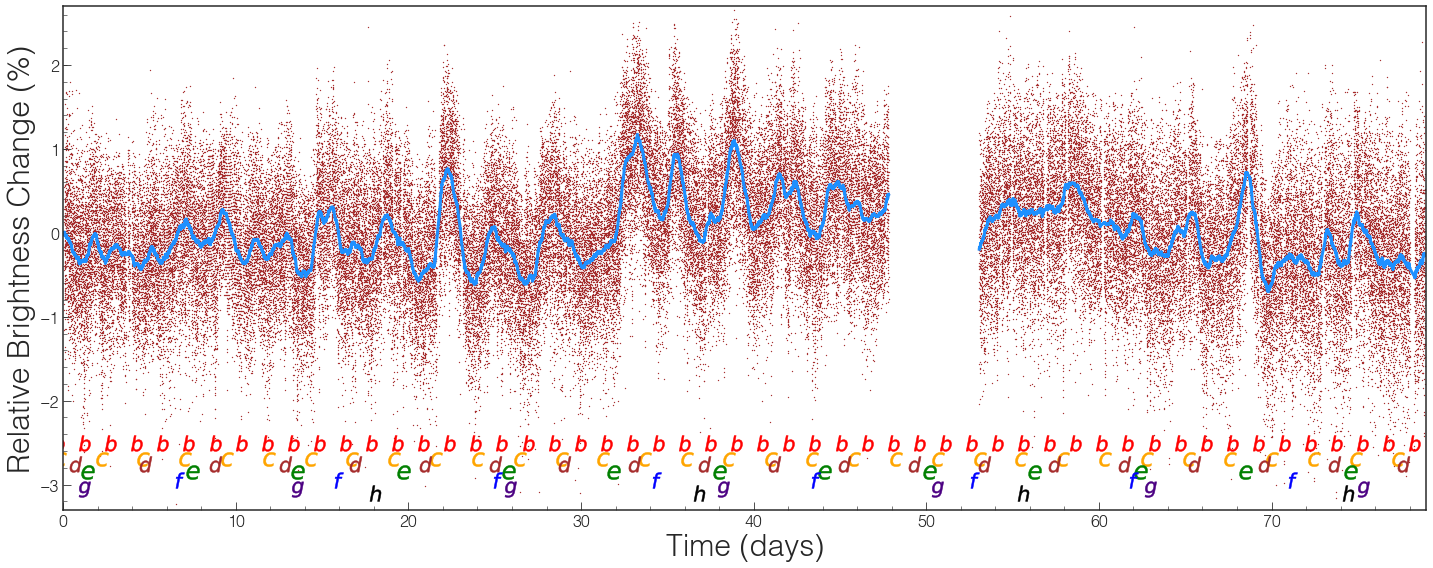

In [58]:
fig, ax2 = plt.subplots(1, 1, figsize=[20,8])


ax2.scatter(t1-2905.3,100*(corflux-1.0), color='brown',s=0.7)
ax2.plot(t1[t1<2955]-2905.3, 100*(q[t1<2955]-1.0), color='dodgerblue', lw=3)
ax2.plot(t1[t1>2955]-2905.3, 100*(q[t1>2955]-1.0), color='dodgerblue', lw=3)

p1 = np.arange(7322.46479891-4833-2905.3, 3000, 1.51104294419)
ax2.scatter(p1,np.zeros_like(p1)-2.8+0.3, color='red', marker=r"$ {} $".format('b'), s=250)

p2 = np.arange(7282.75869097-4833-2905.3, 3000, 2.42204616814)
ax2.scatter(p2,np.zeros_like(p2)-2.9+0.2, color='orange', marker=r"$ {} $".format('c'), s=200)

p3 = np.arange(7670.13107672-4833-2905.3, 3000, 4.05027252205)
ax2.scatter(p3,np.zeros_like(p3)-3.0+0.25, color='brown', marker=r"$ {} $".format('d'), s=250)

p4 = np.arange(7660.37462018-4833-2905.3, 3000, 6.09939207118)
ax2.scatter(p4,np.zeros_like(p4)-3.1+0.25, color='green', marker=r"$ {} $".format('e'), s=200)

p5 = np.arange(7671.36487456-4833-2905.3, 3000, 9.207462181)
ax2.scatter(p5,np.zeros_like(p5)-3.2+0.25, color='blue', marker=r"$ {} $".format('f'), s=250)

p6 = np.arange(7665.34828983-4833-2905.3, 3000, 12.3550553289)
ax2.scatter(p6,np.zeros_like(p6)-3.3+0.25, color='indigo', marker=r"$ {} $".format('g'), s=250)

p7 = np.arange(7756.37685502-4833-2905.3, 3000, 18.7756339642)
ax2.scatter(p7,np.zeros_like(p7)-3.4+0.3, color='black', marker=r"$ {} $".format('h'), s=250)


ax2.set_ylim([-3.3,2.7])
ax2.set_xlim(0, np.max(time)-2905.3)

ax2.set_xlabel('Time (days)', fontsize=30)
ax2.set_ylabel('Relative Brightness Change (%)', fontsize=30)
# ax2.text(2907-2905.3, 2.2,'TRAPPIST-1', fontsize=40, color='dodgerblue')
# ax2.text(2960-2905.3, 2.2,'NASA K2 Mission Data', fontsize=40, color='dodgerblue')
ax2.minorticks_on()
fig.tight_layout()
fig.savefig('images/k2-timeseries.png', dpi=200)

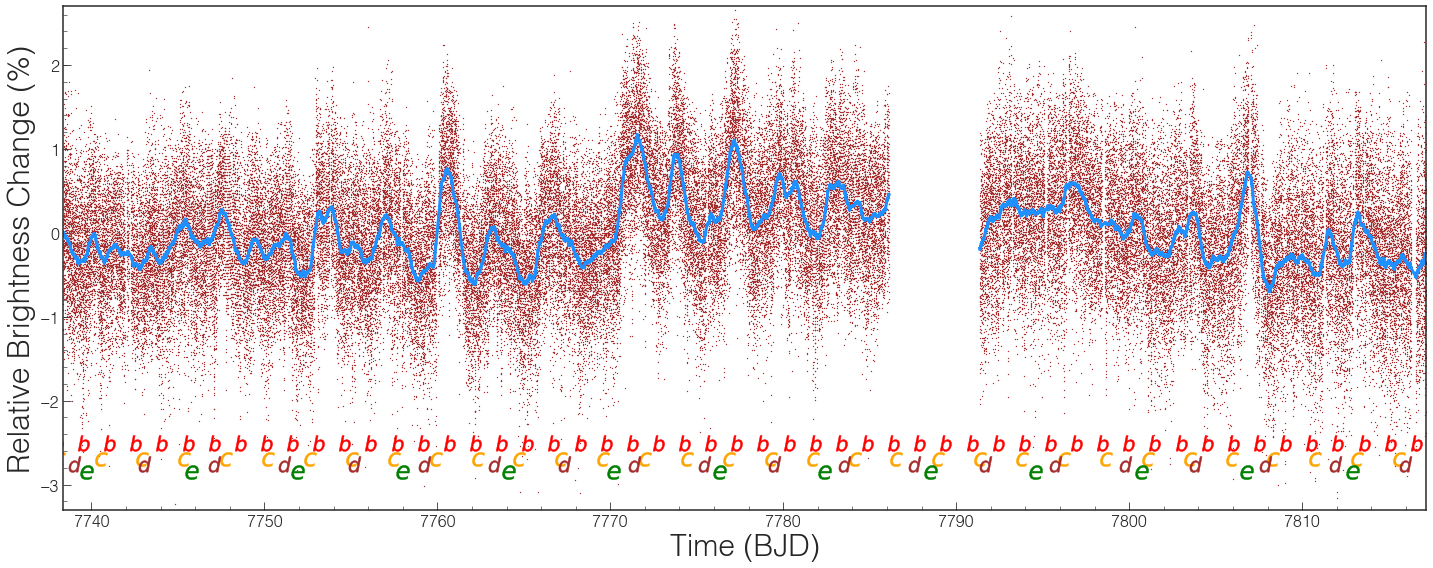

In [87]:
fig, ax2 = plt.subplots(1, 1, figsize=[20,8])


ax2.scatter(t1+4833,100*(corflux-1.0), color='brown',s=0.7)
ax2.plot(t1[t1<2955]+4833, 100*(q[t1<2955]-1.0), color='dodgerblue', lw=3)
ax2.plot(t1[t1>2955]+4833, 100*(q[t1>2955]-1.0), color='dodgerblue', lw=3)

p1 = np.arange(7322.46479891, 3000+4833, 1.51104294419)
ax2.scatter(p1,np.zeros_like(p1)-2.8+0.3, color='red', marker=r"$ {} $".format('b'), s=250)

p2 = np.arange(7282.75869097, 3000+4833, 2.42204616814)
ax2.scatter(p2,np.zeros_like(p2)-2.9+0.2, color='orange', marker=r"$ {} $".format('c'), s=200)

p3 = np.arange(7670.13107672, 3000+4833, 4.05027252205)
ax2.scatter(p3,np.zeros_like(p3)-3.0+0.25, color='brown', marker=r"$ {} $".format('d'), s=250)

p4 = np.arange(7660.37462018, 3000+4833, 6.09939207118)
ax2.scatter(p4,np.zeros_like(p4)-3.1+0.25, color='green', marker=r"$ {} $".format('e'), s=200)

p5 = np.arange(7671.36487456, 3000, 9.207462181)
ax2.scatter(p5,np.zeros_like(p5)-3.2+0.25, color='blue', marker=r"$ {} $".format('f'), s=250)

p6 = np.arange(7665.34828983, 3000, 12.3550553289)
ax2.scatter(p6,np.zeros_like(p6)-3.3+0.25, color='indigo', marker=r"$ {} $".format('g'), s=250)

p7 = np.arange(7756.37685502, 3000, 18.7756339642)
ax2.scatter(p7,np.zeros_like(p7)-3.4+0.3, color='black', marker=r"$ {} $".format('h'), s=250)


ax2.set_ylim([-3.3,2.7])
ax2.set_xlim(np.min(t1)+4833, np.max(t1)+4833)

ax2.set_xlabel('Time (BJD)', fontsize=30)
ax2.set_ylabel('Relative Brightness Change (%)', fontsize=30)
# ax2.text(2907-2905.3, 2.2,'TRAPPIST-1', fontsize=40, color='dodgerblue')
# ax2.text(2960-2905.3, 2.2,'NASA K2 Mission Data', fontsize=40, color='dodgerblue')
ax2.minorticks_on()
fig.tight_layout()
fig.savefig('images/k2-timeseries.pdf', dpi=200)

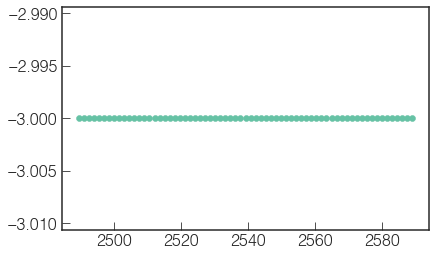

In [46]:
Best-fitting planet parameters for planet 0
impact: 0.286768630101
period: 1.51104294419
T0: 7322.46479891
rprs: 0.0817319125376

Best-fitting planet parameters for planet 1
impact: 0.272728161528
period: 2.42204616814
T0: 7282.75869097
rprs: 0.0802827675081

Best-fitting planet parameters for planet 2
impact: 0.159913567518
period: 4.05027252205
T0: 7670.13107672
rprs: 0.0579609694347

Best-fitting planet parameters for planet 3
impact: 0.30301426224
period: 6.09939207118
T0: 7660.37462018
rprs: 0.0638238106255

Best-fitting planet parameters for planet 4
impact: 0.492000615373
period: 9.207462181
T0: 7671.36487456
rprs: 0.0740537868122

Best-fitting planet parameters for planet 5
impact: 0.482162646842
period: 12.3550553289
T0: 7665.34828983
rprs: 0.0801750007731

Best-fitting planet parameters for planet 6
impact: 0.749113516334
period: 18.7756339642
T0: 7756.37685502
rprs: 0.0673968760204

(3, 15)

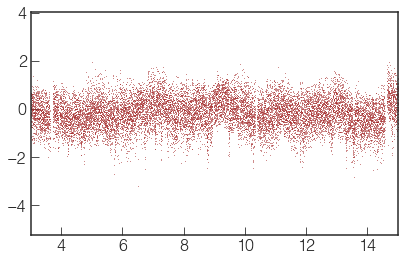

In [19]:
plt.scatter(t1-2905.3,100*(corflux-1.0), color='brown',s=0.1)
plt.xlim(3,15)

In [46]:
b = np.digitize(t1, bins=np.arange(np.min(t1), np.max(t1), 1./48.),)
med = np.array([(np.median(cfflux[b == bx])) for bx in np.unique(b)])
medt = np.array([(np.median(t1[b == bx])) for bx in np.unique(b)])



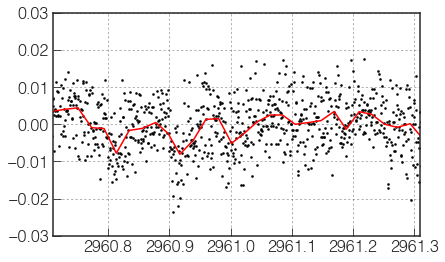

In [86]:

plt.plot(medt,med, color='r')

plt.scatter(t1,cfflux, color='k',s=4)
plt.xlim(2961.01-0.3, 2961.01+0.3)
plt.ylim(-0.03, 0.03)
plt.grid()

In [60]:
idx = np.in1d(np.round(f[1].data['Time'], decimals=7), np.round(t1, decimals=7))

In [74]:
outarr = np.zeros([np.shape(idx)[0]])
j = 0
for i, TF in enumerate(idx):
    if TF:
        outarr[i] = cfflux[j] - fitT.
        j+=1
    else:
        outarr[i] = 0



(2960.71, 2961.3100000000004)

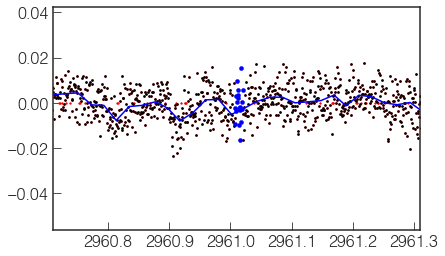

In [99]:
plt.scatter(f[1].data['Time'],outarr, s=3, c='r')
m = np.argwhere((f[1].data['Time']>2961.007) & (f[1].data['Time']<2961.02))
plt.scatter(t1,cfflux, color='k',s=4)
plt.scatter(f[1].data['Time'][m],outarr[m], s=16, c='b')
plt.plot(medt,med, color='b')
plt.xlim(2961.01-0.3, 2961.01+0.3)

In [85]:
np.savetxt('qats/qats/t1.txt', outarr)

In [100]:
np.argwhere((f[1].data['Time']>2961.007) & (f[1].data['Time']<2961.02))

array([[73806],
       [73807],
       [73808],
       [73809],
       [73810],
       [73811],
       [73812],
       [73813],
       [73814],
       [73815],
       [73816],
       [73817],
       [73818],
       [73819],
       [73820],
       [73821],
       [73822],
       [73823],
       [73824]])

(2960, 2965)

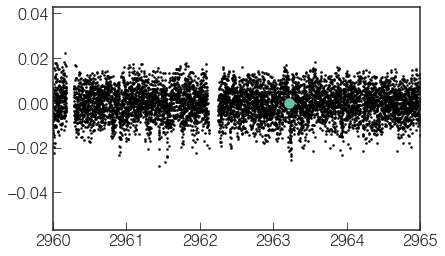

In [110]:
#plt.scatter(f[1].data['Time'],outarr, s=3, c='r')

plt.scatter(t1,cfflux, color='k',s=4)
plt.scatter(f[1].data['Time'][[12759, 42168, 77046, 107215]],[0,0,0,0], s=100)
# plt.scatter(f[1].data['Time'][m],outarr[m], s=16, c='b')
# plt.plot(medt,med, color='b')
# plt.xlim(2961.01-0.3, 2961.01+0.3)
plt.xlim(2960, 2965)


In [2]:
q1 = np.genfromtxt('/Users/tom/gitcode/trappist-lc/trappist1-barclay-short-cadence-fullish.csv', delimiter=',').T
q2 = np.genfromtxt('/Users/tom/gitcode/trappist-lc/trappist1-barclay-short-cadence-fullish-old.csv', delimiter=',').T

tts = np.genfromtxt('/Users/tom/gitcode/trappist-lc/transit-times-songhu').T
ttsout = np.copy(tts)

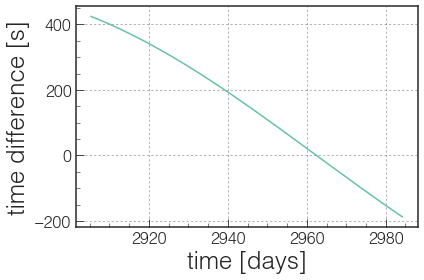

In [3]:
plt.plot(q2[0], (q1[0]-q2[0])*24*60*60)
plt.xlabel('time [days]')
plt.ylabel('time difference [s]')
plt.grid()
plt.minorticks_on()
plt.tight_layout()
# plt.savefig('/Users/tom/gitcode/trappist-lc/images/barycentric.png')

In [165]:
from scipy.interpolate import interp1d

In [166]:
interp = interp1d(q2[0], q1[0], kind='quadratic', )

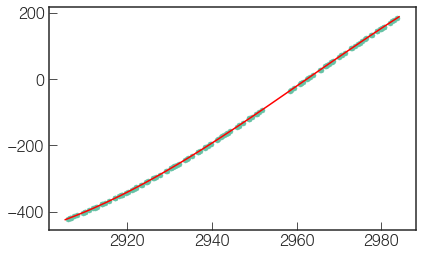

In [167]:
plt.scatter((tts[1]  -2454833), 24*60*60 * ((tts[1]  -2454833) - interp((tts[1]  -2454833))), marker='.', s=100)
plt.plot(q1[0], (q2[0]-q1[0])*24*60*60, 'r-')
# plt.xlim(2920,2925)
# plt.ylim(-360,-300)

In [168]:
interp(tts[1]  -2454833)

array([ 2906.51716746,  2908.02878166,  2909.5385638 ,  2911.05143423,
        2912.5614408 ,  2914.07910504,  2915.58305139,  2917.09288714,
        2918.60551718,  2920.11668149,  2921.62628106,  2923.13840299,
        2924.64808679,  2926.16224178,  2927.67088317,  2929.18133453,
        2930.69434173,  2932.20276838,  2933.71458999,  2935.2261884 ,
        2936.73617724,  2938.24785058,  2939.75992662,  2941.26929113,
        2942.77992039,  2944.28901903,  2945.80194501,  2947.31240462,
        2948.82431802,  2950.33566533,  2951.84345195,  2959.39842332,
        2960.91208422,  2962.41730333,  2963.93184111,  2965.44299006,
        2966.95395619,  2968.46424382,  2969.97589465,  2971.48723842,
        2972.99798352,  2974.50864942,  2976.01838068,  2977.52982836,
        2979.04033251,  2980.55128927,  2982.06266796,  2983.57615728,
        2907.52990533,  2909.95200041,  2912.37715831,  2914.79694043,
        2917.21864801,  2919.6389017 ,  2922.0591066 ,  2924.48274313,
      

In [169]:
ttsout[1] = (interp(tts[1]  -2454833) + 2454833)

In [170]:
np.savetxt('transit-times-barycentric.txt', ttsout.T, ['%i', '%.10f', '%.10f', '%i', '%i', '%i', '%i'])


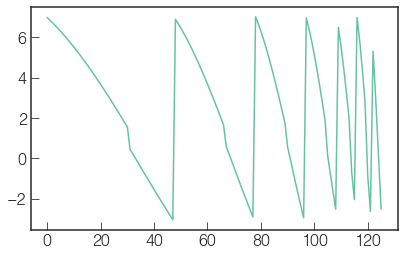

In [171]:
plt.plot((ttsout[1] - tts[1]) * 1440)

In [76]:
t1[0]+4833

7738.3669311669655